# Clustering for evaluation of CDSS
In this notebook we try to cluster for the branches of the decision tree underlying DYNAMIC's CDSS which are diagnoses. A good clustering result is thus achieved if the clusters correspond to the diagnoses considered by the CDSS. This requires testing several clustering approaches which are implemented here. The approaches are the following...
1. K-Prototypes
2. K-Means with features preprocessed as for K-Prototypes
3. K-Means with features preprocessed with domain knowledge

The evaluation of each clustering approach is done in the notebook: evaluate-clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

# Import and data wrangling


In [2]:
# import cleaned and prepared data of consultations in RW
data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

## Get features
- selection and engineering of features
- normalization
    - transform NAN values into uniform format which is `np.nan`

In [3]:
# variables containing relevant column names
demographic_columns = [
    #"patient_id",
    "patient_age",
    "patient_gender"
]

symptoms_of_interest = ["PE212 - Respiratory rate (breaths/min) - 8469",
    "S39 - Cough - 7817", 
    "PE18 - Chest indrawing - 7811",
    "S180 - How is the infant feeding currently? - 7516",
    "S46 - Convulsions in present illness - 8355",
    "BC - Axillary temperature - 7823 categorical",
    "PE125 - Observation of movement - 8388",
    "S96 - Unable to drink or breastfeed - 7871",
    "S157 - Vomiting everything - 8026",
    "OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378",
    "PE63 - Stiff neck - 8391",
    "PE19 - Stridor in calm child - 7812",
    "S42 - Duration of fever (days) - 7819 categorical",
    "S124 - Significant weight loss - 7539",
    "S118 - Significant hemoptysis (>1 episode) - 7941",
    "S176 - Cough duration (days) - 7731 categorical",
    "E46 - Recent close contact with somebody with TB - 7820",
    "PE220 - Identifiable source of fever? - 8399",
    "A55 - Urinary dipstick - 7648",
    "PE134 - Measles rash and associated signs - 8386",
    "PE109 - Scarlet fever rash - 8344",
    "PE106 - Non specific viral rash - 7930",
    "PE218 - Unexplained bleeding - 8107",
    "S153 - Diarrhea (stools are looser or more watery than normal) - 7649",
    "S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical",
    "S149 - Yellow appearing skin or eyes (jaundice) - 7630",
    "PE191 - Jaundice - 8036",
    "S74 - Abnormal vaginal discharge - 8377",
    "S81 - Urethral discharge - 7810",
    "S79 - Genital lesion - 7867",
    "BC7 - Weight for age (z-score) - 8434 categorical",
    "BC95 - Weight for height - 7451 categorical",
    "BC61 - MUAC for age z-score - 7839 categorical"#formr: "BC - MUAC in cm - 7833 categorical"
]

# add symptoms which appear in several columns because they are actually diagnoses
symptoms_to_find = ["fever without source: presumed bacterial infection", "fever without source: presumed viral illness", "suspicion of tuberculosis"]
symptoms_to_add = [s for symp in symptoms_to_find for s in data.columns if symp in s]
print("Adding the following", len(symptoms_to_add), "symptoms to symptoms_of_interest:\n", symptoms_to_add)
symptoms_of_interest = symptoms_of_interest + symptoms_to_add

Adding the following 12 symptoms to symptoms_of_interest:
 ['DF130 - fever without source: presumed bacterial infection - 30851', 'DF - fever without source: presumed bacterial infection - 26194', 'DF130 - fever without source: presumed bacterial infection - 8480', 'DF130 - fever without source: presumed bacterial infection - 30602', 'DF129 - fever without source: presumed viral illness - 30853', 'DF - fever without source: presumed viral illness - 26192', 'DF129 - fever without source: presumed viral illness - 8481', 'DF129 - fever without source: presumed viral illness - 30604', 'DF9 - suspicion of tuberculosis - 30886', 'DF - suspicion of tuberculosis - 26232', 'DF9 - suspicion of tuberculosis - 8539', 'DF9 - suspicion of tuberculosis - 30643']


In [4]:
# select features for clustering
features = data[np.concatenate((demographic_columns, symptoms_of_interest))]

# engineer malaria feature based on instructions of domain experts
features["malaria"] = data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(data["A50 - Microscopy for malarial parasites - 7837 categorical"])]
features.loc[features["malaria"].isna(), "malaria"] == data.loc[features["malaria"].isna(), "A51 - Malaria rapid diagnostic test - 7838 categorical"]

# number of consultation which have no value in "A50 - Microscopy for malarial parasites - 7837 categorical" but a value in "A50 - Microscopy for malarial parasites - 7837 categorical"
sum(data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna() & ~data["A50 - Microscopy for malarial parasites - 7837 categorical"].isna())

# engineer diagnoses features: 
# get features which are diagnosis, merge them and add replace them with merged and final feature
list_diagnoses_as_features = [col for col in features.columns if col[0:2] == "DF"]
diagnoses_data_as_features = features[list_diagnoses_as_features]
diagnoses_data_as_features.columns = [col.split(" - ")[1] for col in diagnoses_data_as_features.columns]
diagnoses_data_as_features = diagnoses_data_as_features.groupby(diagnoses_data_as_features.columns, axis=1, dropna=False).sum(min_count=1)
diagnoses_data_as_features = diagnoses_data_as_features.fillna(0) # NAN = Rejected = 0
diagnoses_data_as_features[diagnoses_data_as_features != 0] = 1 # make binary: 0=diagnosis not there, 1=diagnosis there (due to the upper merge a diagnosis is there but has a value like 2 or 3)

# add final and merged diagnoses features
for col in diagnoses_data_as_features.columns:
    features[col] = diagnoses_data_as_features[col]

# drop original diagnosis features
features = features.drop(columns=list_diagnoses_as_features, axis=1)

# normalize NAN values in data
features = features.apply(lambda x : x.replace({
    "not_available": np.nan, 
    'Test/Assessment is unavailable': np.nan, # for malaria feature
    'Unavailable': np.nan
    }), 
    axis=1
)

# convert to float if possible
features = features.astype(float, errors="ignore")

# reset index
features = features.reset_index(drop=True)

C:\Users\sidla\AppData\Local\Temp\ipykernel_8808\2702252366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["malaria"] = data["A50 - Microscopy for malarial parasites - 7837 categorical"]#[e if e == np.nan else data["A51 - Malaria rapid diagnostic test - 7838 categorical"][i] for i, e in enumerate(data["A50 - Microscopy for malarial parasites - 7837 categorical"])]
C:\Users\sidla\AppData\Local\Temp\ipykernel_8808\2702252366.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = di

## Get diagnoses (= desired labels)

In [5]:
diagnoses_to_consider = ["Abortion",
   "Abscess",
   "Acute diarrhea",
   "Acute limp or joint pain",
   "Acute otitis media (ear infection)",
   "Allergic conjunctivitis",
   "Anaphylaxis",
   "Bacterial acute pharyngitis",
   "Bacterial conjunctivitis",
   "Bacterial conjunctivitis (< 5 y)",
   "Bacterial pneumonia",
   "Balanitis",
   "Bronchial asthma",
   "Burn",
   "Cellulitis",
   "Chronic ear infection",
   "Chronic limp or joint pain",
   "CNS Danger signs",
   "Common Cold",
   "Complicated abscess",
   "Complicated acute ear infection",
   "Complicated cellulitis",
   "Complicated chicken pox",
   "Complicated deep wound",
   "Complicated impetigo",
   "Complicated neck mass",
   "Complicated prolonged fever",
   "Complicated severe acute malnutrition",
   "Complicated superficial wound",
   "Concern for congenital syndrome or malformation",
   "Confirmed dislocation",
   "Congenital condition",
   "Congenital muscular torticollis",
   "Conjunctivitis",
   "Constipation",
   "Contusion",
   "Convulsions",
   "Corneal abrasion",
   "Critical illness",
   "Dental abscess",
   "Dental emergency",
   "Diaper rash",
   "Diarrhea with no dehydration",
   "Diarrhea with severe dehydration",
   "Diarrhea with some dehydration",
   "Dysentery",
   "Dysentery (Bloody diarrhea)",
   "Ear infection (otitis), acute",
   "Ear infection (otitis), chronic",
   "Eczema (Atopic dermatitis)",
   "Emergency / danger signs",
   "Epilepsy",
   "Extensive folliculitis",
   "Eye disease, infectious",
   "Eye disease, non-infectious",
   "Febrile urinary tract infection",
   "Feeding problem",
   "Feeding problem (Insufficient feeds)",
   "Feeding problem (lack of exclusive breastfeeding)",
   "Feeding problem (lactation)",
   "Fever without source",
   "Folliculitis",
   "Follow-up consultation",
   "Foreign body in ear",
   "Fracture",
   "Generalized (extensive) tinea corporis",
   "Heat rash",
   "Herpes simplex - Oral lesions (herpes labialis)",
   "HIV exposed",
   "Hyperglycemia",
   "Hypoglycemia",
   "IMCI Anemia",
   "IMCI Severe Anemia",
   "IMCI/IMAI pneumonia",
   "Improved conjunctivitis",
   "Influenza",
   "Inguinal hernia",
   "Intestinal parasites",
   "Intestinal parasitic infection: Nematode",
   "Intestinal parasitic infection: Protozoa",
   "Local skin infection",
   "Loss of appetite",
   "Low weight for age",
   "Lower urinary tract infection (cystitis)",
   "Major burn",
   "Major head injury",
   "Major trauma",
   "Malaria",
   "Mastitis",
   "Mastoiditis",
   "Measles",
   "Meningitis",
   "Mild croup",
   "Mild/Moderate anemia",
   "Minor burn",
   "Minor head injury",
   "Moderate head injury",
   "Moderate malnutrition",
   "Molluscum contagiosum",
   "Mumps",
   "Neonatal conjunctivitis - (includes possible gonococcal / chlamydia infection )",
   "Neonatal sepsis",
   "Non-severe abdominal condition",
   "Non-severe headache",
   "Non-severe measles",
   "Non specific viral rash",
   "Omphalitis",
   "Omphalitis complicated / severe",
   "Oral aphthous ulcers",
   "Oral candidiasis",
   "Oral thrush",
   "Orbital cellulitis",
   "Osteomyelitis / septic arthritis",
   "Osteomyelitis/septic arthritis",
   "Oxyuriasis (rectal symptoms/worms in stool)",
   "Pathologic-prolonged jaundice",
   "Pathologic-severe jaundice",
   "Pediculosis (Head lice)",
   "Pelvic Inflammatory disease",
   "Persistent diarrhea",
   "Physical trauma",
   "Physiologic rash : Erythema toxicum",
   "Physiologic rash : transient neonatal pustural melanosis",
   "Physiological jaundice",
   "Pityriasis versicolor",
   "Pneumonia",
   "Pneumonia, non-severe",
   "Pneumonia, severe",
   "Preseptal cellulitis",
   "Primary Syphilis",
   "Prolonged fever",
   "Pyelonephritis",
   "Reactive airway disease",
   "Respiratory tract infection (viral suspected)",
   "Road traffic accident",
   "Scabies",
   "Scarlet fever",
   "Severe abdominal condition",
   "Severe abdominal condition (possible bowel obstruction / hernia / appendicitis)",
   "Severe abdominal problem",
   "Severe anemia",
   "Severe Clinical infection or Severe illness",
   "Severe Croup",
   "Severe dehydration",
   "Severe eye disease",
   "Severe eye problem",
   "Severe malaria",
   "Severe malnutrition",
   "Severe pneumonia",
   "Severe skin infection",
   "Sexually transmitted infection (STI)",
   "Sickle cell disease",
   "Significant hemoptysis",
   "Simple abscess",
   "Skin Condition, non-infectious",
   "Skin infection, fungal",
   "Skin infection, non-fungal",
   "Some dehydration",
   "STI Genital discharge syndrome",
   "Suspected malaria",
   "Suspected severe malaria",
   "Suspected testicular torsion",
   "Suspicion of foreign object in airways",
   "Suspicion of fracture/dislocation",
   "Suspicion of meningitis",
   "Suspicion of poisoning",
   "Suspicion of tuberculosis",
   "Tinea capitis",
   "Tinea corporis",
   "Tooth pain",
   "Typhoid Fever",
   "Uncomplicated acute ear infection",
   "Uncomplicated cellulitis",
   "Uncomplicated chicken pox",
   "Uncomplicated deep wound",
   "Uncomplicated impetigo",
   "Uncomplicated infectious lymphadenitis",
   "Uncomplicated lymphadenopathy",
   "Uncomplicated Malaria",
   "Uncomplicated severe acute malnutrition",
   "Uncomplicated superficial wound",
   "Uncomplicated suspicion of poisoning",
   "Uncomplicated vomiting",
   "Upper respiratory infection",
   "Urinary tract infection (UTI)",
   "Urticaria",
   "Vaginal candidiasis",
   "Vaginal discharge syndrome (Presumed Gonorrhea/ Chlamydia / Trichomoniasis / Bacterial Vaginosis)",
   "Very low weight for age",
   "Very severe febrile disease",
   "Viral acute pharyngitis",
   "Viral conjunctivitis",
   "Viral conjunctivitis (< 5y)",
   "Viral pneumonia",
   "Vulvovaginitis",
   "Wound"]
diagnoses_of_interest = [col for n in diagnoses_to_consider for col in data.columns if (n.lower() in col) & (col[0:2] == "DF") & (~(col in symptoms_of_interest))]
print("number of diagnoses of interest:", len(diagnoses_of_interest))

number of diagnoses of interest: 1169


In [6]:
# get diagnosed diagnoses
raw_diagnoses = data[diagnoses_of_interest]
raw_diagnoses = raw_diagnoses.dropna(axis=1, how='all') # drop diagnoses which were not diagnosed once

# normalize: Accepted = 1, Rejected = 0, NAN = 0, assume doctor's diagnosis = CDSS's diagnosis (= "Manually added": 1)
raw_diagnoses = raw_diagnoses.apply(lambda x : x.replace({"Accepted": 1, "Rejected": 0, "Manually added": 1}), axis=1) 

# merge diagnoses that are separated over several columns 
# (e. g. DF9 - suspicion of tuberculosis – 30886, DF - suspicion of tuberculosis – 26232 are two columns for the same diagnosis)
list_diagnoses = [d.split(" - ")[1] for d in raw_diagnoses.columns]
diagnoses = raw_diagnoses.groupby(list_diagnoses, axis=1, dropna=False).sum(min_count=1) #min_count=1 ensures that sum of only NAN is NAN and that same diagnoses are correctly merged

# NAN = Rejected = 0
diagnoses = diagnoses.fillna(0)

# make binary: 0=diagnosis not there, 1=diagnosis there (due to the upper merge a diagnosis is there but has a value like 2 or 3)
diagnoses[diagnoses != 0] = 1

# summarize diagnoses used for further analysis
print("After cleaning and merging columns of the same diagnosis,", diagnoses.shape[1], "diagnoses are considered. Before there were", raw_diagnoses.shape[1], "diagnoses.")

# find diagnoses that were merged and summed together so that value is bigger than 1 (and thus not binary anymore)
for c in diagnoses.columns:
    if(all(val > 1.0 for val in diagnoses[c].unique())):
        print(c+":", diagnoses[c].unique())
        
# check if all diagnoses are binary
binary_diagnoses = diagnoses.nunique(dropna=True).loc[lambda x : x <= 2].index
print("Percentage binary diagnoses:", len(binary_diagnoses)/diagnoses.shape[1])

# print non binary diagnosis
for non_binary_diagnosis in [c for c in diagnoses.columns if not c in binary_diagnoses]:
    print(non_binary_diagnosis+":", diagnoses[non_binary_diagnosis].unique())

#reset index
diagnoses = diagnoses.reset_index(drop=True)

After cleaning and merging columns of the same diagnosis, 169 diagnoses are considered. Before there were 627 diagnoses.
Percentage binary diagnoses: 1.0


# Store preprocessed diagnoses and features as pickles for other notebooks

In [7]:
# store features and diagnoses as pickles
features.to_pickle("data/rwanda/features.pickle")
diagnoses.to_pickle("data/rwanda/diagnoses.pickle")

# Preprocessing

## General preprocessing

In [10]:
# drop consultations containing not at least one of the top 10 diagnoses
top10_diagnoses = diagnoses.sum().sort_values(ascending=False).to_frame().reset_index().head(10)
top10_diagnoses.columns = ["diagnosis", "number_consultations"]
idx_consultations_with_top10_diagnoses = diagnoses[top10_diagnoses["diagnosis"]].sum(axis=1) > 0
features_of_top10_diagnoses = features[idx_consultations_with_top10_diagnoses]

In [13]:
features_of_top10_diagnoses.to_pickle("data/rwanda/features_consultations_with_at_least_one_top_10_diagnosis")
diagnoses.loc[idx_consultations_with_top10_diagnoses, top10_diagnoses["diagnosis"]].to_pickle("data/rwanda/diagnoses_consultations_with_at_least_one_top_10_diagnosis")

## Preprocessing for clustering approaches
The following preprocessing is done for the clustering approaches:
1. K-Prototypes
    - impute missing values of numerical features with median if binary/categorical or mean if continues
    - stringify missing values of non-numerical features (=binary or categorical), making missingness an additional category
    - standardize numerical features
2. K-Means with features preprocessed as for K-Prototypes
    - impute missing values of numerical features with median if binary/categorical or mean if continues
    - stringify missing values of non-numerical features (=binary or categorical), making missingness an additional category
    - one-hot encode all non-numerical features
    - standardize all features
3. K-Means with features preprocessed with domain knowledge
    - numericalise non-numerical features based on domain knowledge so that ordinal scale of categorical features is maintained
    - impute missing values of medical features based on domain knowledge so that NAN corresponds to the value a healthy/normal patient would have had for the respective feature
    - impute missing values of demographic features with median if binary/categorical or mean if continues (No NAN in demographics)

In [14]:
from sklearn.preprocessing import StandardScaler

## K-Prototypes

In [15]:
k_prototypes_preprocessed_features = features_of_top10_diagnoses.copy()

# impute features based on data type
for col in k_prototypes_preprocessed_features.columns:
    if "float" in str(k_prototypes_preprocessed_features[col].dtype): # if continues feature
        number_unique_values = len(k_prototypes_preprocessed_features[col].dropna().unique())
        if number_unique_values <=2: #if numerical binary column
            # stringify NAN values
            k_prototypes_preprocessed_features[col] = k_prototypes_preprocessed_features[col].fillna("missing")

            # stringify values
            k_prototypes_preprocessed_features[col] = k_prototypes_preprocessed_features[col].astype(str)
            print(col, "'s missing values were stringified and thus added as an extra category")
        else: 
            # impute with mean
            k_prototypes_preprocessed_features[col] = k_prototypes_preprocessed_features[col].fillna(np.mean(k_prototypes_preprocessed_features[col]))
            print(col, "'s missing values were imputted using mean")
    elif "int" in str(k_prototypes_preprocessed_features[col].dtype): # if discrete feature
        # impute with median
        k_prototypes_preprocessed_features[col] = k_prototypes_preprocessed_features[col].fillna(np.median(k_prototypes_preprocessed_features[col]))
        print(col, "'s missing values were imputted using median")
    else: # if binary or categorical feature 
        # stringify NAN values
        k_prototypes_preprocessed_features[col] = k_prototypes_preprocessed_features[col].fillna("missing")
        print(col, "'s missing values were stringified and thus added as an extra category")

# scale remaining numerical features to avoid favouring of features in euclidian distance
numerical_features = [k_prototypes_preprocessed_features.dtypes.index[i] for i, e in enumerate(k_prototypes_preprocessed_features.dtypes) if "float" in str(e) or "int" in str(e)]
scaler = StandardScaler()
k_prototypes_preprocessed_features[numerical_features] = scaler.fit_transform(k_prototypes_preprocessed_features[numerical_features])

# check if there are no missing values anymore  
print("Number of missing values in features after preprocessing:", k_prototypes_preprocessed_features.isna().sum().sum())

patient_age 's missing values were imputted using mean
patient_gender 's missing values were stringified and thus added as an extra category
PE212 - Respiratory rate (breaths/min) - 8469 's missing values were imputted using mean
S39 - Cough - 7817 's missing values were stringified and thus added as an extra category
PE18 - Chest indrawing - 7811 's missing values were stringified and thus added as an extra category
S180 - How is the infant feeding currently? - 7516 's missing values were stringified and thus added as an extra category
S46 - Convulsions in present illness - 8355 's missing values were stringified and thus added as an extra category
BC - Axillary temperature - 7823 categorical 's missing values were stringified and thus added as an extra category
PE125 - Observation of movement - 8388 's missing values were stringified and thus added as an extra category
S96 - Unable to drink or breastfeed - 7871 's missing values were stringified and thus added as an extra category
S1

## K-Means with features preprocessed as for K-Prototypes


In [16]:
k_means_with_k_prototypes_preprocessed_features = k_prototypes_preprocessed_features.copy()

# one hot encode all non-numerical features
non_numerical_features = [k_means_with_k_prototypes_preprocessed_features.dtypes.index[i] for i, e in enumerate(k_means_with_k_prototypes_preprocessed_features.dtypes) if e == "object"]
new_numerical_features = []
for feature in non_numerical_features:
    encoded_feature = pd.get_dummies(k_means_with_k_prototypes_preprocessed_features[feature], prefix=feature+"_")
    for new_feature in encoded_feature.columns:
        k_means_with_k_prototypes_preprocessed_features[new_feature] = encoded_feature[new_feature]
        new_numerical_features.append(new_feature)
    

# drop original columns after one hot encoding
k_means_with_k_prototypes_preprocessed_features = k_means_with_k_prototypes_preprocessed_features.drop(non_numerical_features, axis=1)

# standardize all features
# NOTE due to copying of k_prototypes_preprocessed_features only newly numericalised non-numerical features need to be standardized
scaler = StandardScaler()
k_means_with_k_prototypes_preprocessed_features[new_numerical_features] = scaler.fit_transform(k_means_with_k_prototypes_preprocessed_features[new_numerical_features])

C:\Users\sidla\AppData\Local\Temp\ipykernel_8808\580835186.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  k_means_with_k_prototypes_preprocessed_features[new_feature] = encoded_feature[new_feature]
C:\Users\sidla\AppData\Local\Temp\ipykernel_8808\580835186.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  k_means_with_k_prototypes_preprocessed_features[new_feature] = encoded_feature[new_feature]
C:\Users\sidla\AppData\Local\Temp\ipykernel_8808\580835186.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is us

## K-Means with features preprocessed with domain knowledge

In [17]:
# imputate and numericalize based on domain and context
k_means_preprocessed_with_domain_knowledge = features_of_top10_diagnoses.copy()

# rules for imputing and numericalisation
domain_based_data_preprocessing = {
        'patient_age': {"method":"median"}, # "method" refers to the NAN processing method
        'patient_gender': {"method":"median", "conversion":{"female": 1, "male": 0}},
        'PE212 - Respiratory rate (breaths/min) - 8469': {"method":"domain", "conversion":{np.nan : 14}},  # check wth doman if nan = 14 makes sense
        'S39 - Cough - 7817': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE18 - Chest indrawing - 7811': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S180 - How is the infant feeding currently? - 7516': {"method":"domain", "conversion":{np.nan : 0, 'Feeding well': 0, 'Not feeding well': 1, 'Not feeding at all': 2}},
        'S46 - Convulsions in present illness - 8355': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'BC - Axillary temperature - 7823 categorical': {"method":"domain", "conversion":{np.nan : 0, "< 38 °C": 0, ">= 38°C": 1}}, # check wth doman if nan = 0 makes sense
        'PE125 - Observation of movement - 8388': {"method":"domain", "conversion":{np.nan : 0, 'Movement without stimulation': 0, 'Movement only when stimulated': 1, 'No movement even when stimulated': 2}},
        'S96 - Unable to drink or breastfeed - 7871': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S157 - Vomiting everything - 8026': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE63 - Stiff neck - 8391': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}}, 
        'PE19 - Stridor in calm child - 7812': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S42 - Duration of fever (days) - 7819 categorical': {"method":"domain", "conversion":{np.nan : 0, '< 4 days': 1, '>= 4 days < 7 days': 2, '>= 7 days < 14 days': 3, '>= 14 days': 4}},
        'S124 - Significant weight loss - 7539': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S118 - Significant hemoptysis (>1 episode) - 7941': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S176 - Cough duration (days) - 7731 categorical': {"method":"domain", "conversion":{np.nan : 0, "< 2 weeks": 1, ">= 2 weeks": 2}},
        'E46 - Recent close contact with somebody with TB - 7820': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE220 - Identifiable source of fever? - 8399': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'A55 - Urinary dipstick - 7648': {"method":"domain", "conversion":{np.nan : 0, "Pathologic": 1, "Normal": 0}},
        'PE134 - Measles rash and associated signs - 8386': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE109 - Scarlet fever rash - 8344': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE106 - Non specific viral rash - 7930': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE218 - Unexplained bleeding - 8107': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'S153 - Diarrhea (stools are looser or more watery than normal) - 7649': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical': {"method":"domain", "conversion":{np.nan : 0, '<3': 1, '>=3': 2, '>=4': 3, '>=5': 4, '>=6': 5}},
        'S149 - Yellow appearing skin or eyes (jaundice) - 7630': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE191 - Jaundice - 8036': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'S74 - Abnormal vaginal discharge - 8377': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S81 - Urethral discharge - 7810': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}}, 
        'S79 - Genital lesion - 7867': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'BC7 - Weight for age (z-score) - 8434 categorical': {"method":"domain", "conversion":{np.nan : 0, "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2}}, # check wth doman if nan =0 makes sense
                'BC95 - Weight for height - 7451 categorical': {"method":"domain", "conversion":{np.nan : 0, "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2}}, # check wth doman if nan = 0 makes sense
                "BC61 - MUAC for age z-score - 7839 categorical": {"method":"domain", "conversion":{np.nan : 0, '> - 2 z-score': 0, "-2 z-score": 1, '< -2 z-score': 2}},
        'malaria': {"method":"domain", "conversion":{np.nan : 0, "Positive": 1, "Negative": 0}},
                'fever without source: presumed bacterial infection': {"method":"domain", "conversion":{np.nan : 0, 'Accepted': 1, 'Manually added': 1, 'Rejected': 0,}}, # check wth doman if nan = 0 makes sense
                'fever without source: presumed viral illness': {"method":"domain", "conversion":{np.nan : 0, 'Accepted': 1, 'Manually added': 1, 'Rejected': 0,}}, # check wth doman if nan = 0 makes sense
        'suspicion of tuberculosis': {"method":"domain", "conversion":{np.nan : 0, "Accepted": 1, "Rejected": 0}}# check wth doman if nan = 0 makes sense
}

# impute nan and numericalise features based on domain knowledge
for feature in domain_based_data_preprocessing:
        if "conversion" in domain_based_data_preprocessing[feature]: 
                k_means_preprocessed_with_domain_knowledge[feature] = k_means_preprocessed_with_domain_knowledge[feature].replace(domain_based_data_preprocessing[feature]["conversion"])
        if domain_based_data_preprocessing[feature]["method"] == "median": 
                median=k_means_preprocessed_with_domain_knowledge[feature].median()
                k_means_preprocessed_with_domain_knowledge[feature] = k_means_preprocessed_with_domain_knowledge[feature].fillna(median)
        if domain_based_data_preprocessing[feature]["method"] == "mean": 
                mean=k_means_preprocessed_with_domain_knowledge[feature].mean()
                k_means_preprocessed_with_domain_knowledge[feature] = k_means_preprocessed_with_domain_knowledge[feature].fillna(mean)

# convert features to float 
k_means_preprocessed_with_domain_knowledge = k_means_preprocessed_with_domain_knowledge.astype(float)

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(k_means_preprocessed_with_domain_knowledge)
k_means_preprocessed_with_domain_knowledge = pd.DataFrame(scaled_features, columns=k_means_preprocessed_with_domain_knowledge.columns)

# check if there are no missing values anymore  
print("Number of missing values in features after preprocessing:", k_means_preprocessed_with_domain_knowledge.isna().sum().sum())

Number of missing values in features after preprocessing: 0


# Clustering

In [18]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator

# FUNCTIONS
#Elbow method to detect optimal number of K in K-Prototypes
# NOTE This takes a long time  > 45 minutes
def elbow_method_for_k_prototypes(data):
    #convert to matrix
    dfMatrix = data.to_numpy()

    # get positions of categorical and binary features
    catFeaturesPos = [i for i, f in enumerate(data.dtypes) if f == "object"]

    # perform elbow method
    cost = []
    for cluster in range(1, 10):
        try:
            kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = cluster*1000)
            kprototype.fit_predict(dfMatrix, categorical = catFeaturesPos)
            cost.append(kprototype.cost_)
            print('Cluster initiation: {}'.format(cluster))
        except:
            break
    fig = plt.figure()
    plt.plot(cost, figure=fig)
    plt.xlabel('K', figure=fig)
    plt.ylabel('Cost', figure=fig)
    plt.title("Elbow graph for clustering approach:'K-Prototypes'", figure=fig)
    fig.savefig(f"plots/evaluation_of_clustering_approches/elbow-method-results/K-Prototypes.png")
    plt.show()
    
    # cost (sum distance): confirm visual clue of elbow plot
    # KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
    cost_knee_c3 = KneeLocator(
            x=range(1,10), 
            y=cost, 
            S=0.1, curve="convex", direction="decreasing", online=True)

    K_cost_c3 = cost_knee_c3.elbow   
    print("elbow at k =", f'{K_cost_c3:.0f} clusters')

# cluster data with K-prototypes and manually set k 
def clustering_with_k_prototypes(data, k, random_state):
    #convert to matrix
    dfMatrix = data.to_numpy()

    # get positions of categorical and binary features
    catFeaturesPos = [i for i, f in enumerate(data.dtypes) if f == "object"]

    # perform clustering
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', n_init=100, random_state=random_state) # n_clusters = K_cost_c3
    data['cluster'] = kprototype.fit_predict(dfMatrix, categorical = catFeaturesPos)

    return data

# cluster data with K-Means and manually set k and 
# manually set title for Elbow method plot and the option ot init clusters with custom centroids
def clustering_with_k_means(data, k, centroids, random_state, title):
    # Finding the optimal number of clusters using the Elbow method with yellowbrick
    model = KMeans(n_init=10, random_state=random_state*100)
    visualizer = KElbowVisualizer(model, k=(1,k+10), title=title)
    visualizer.fit(data)
    n_clusters = visualizer.elbow_value_ # optimal number of clusters
    visualizer.show()

    # perform clustering with manual init or k-means++ as default with 100 inits
    if centroids == True:
        # get centroids based on mean of features when desired diagnoses (= 10 most common diagnoses) are given
        centroids = [] # should be of shape (n_clusters, n_features)
        for d in diagnoses.sum().sort_values(ascending=False).head(10).index:
            temp = data.copy() # copy features
            temp[d] = diagnoses[d] # add respective diagnosis
            centroids.append(temp.loc[temp[d] == 1, data.columns].mean().values) # compute mean of ever feature for cases when diagnoses was present (=1)
        centroids = np.array(centroids, dtype=float)

        #perform clustering
        kmeans = KMeans(n_clusters=k, init=centroids, random_state=random_state).fit(data)
    else:
        kmeans = KMeans(n_clusters=k, n_init=100, random_state=random_state).fit(data)
    # Adding the column 'cluster' to the dataframe
    data["cluster"] = kmeans.labels_

    return data

## Set desired cluster size

In [27]:
K = 10 #alternatively set to: "elbow" to use K according to respective clustering approaches' optimal K based on elbow method --> is bound to longer computation time

## K-Prototypes

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


TypeError: show() got an unexpected keyword argument 'figure'

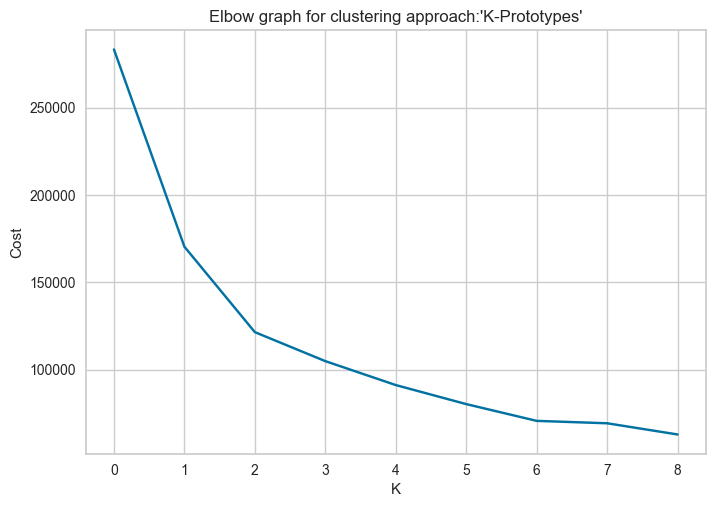

In [32]:
#elbow_method_for_k_prototypes(k_prototypes_preprocessed_features)

In [34]:
clustering_with_k_prototypes(k_prototypes_preprocessed_features, K, 1).to_pickle("data/rwanda/clustering_results/k_prototypes_preprocessed_features.pickle")

## K-Means

In [35]:
k_means_manual_inint_with_k_prototypes_preprocessed_features = k_means_with_k_prototypes_preprocessed_features.copy()
k_means_manual_init_and_preprocessed_with_domain_knowledge = k_means_preprocessed_with_domain_knowledge.copy()

## ... with default init and n_init=100

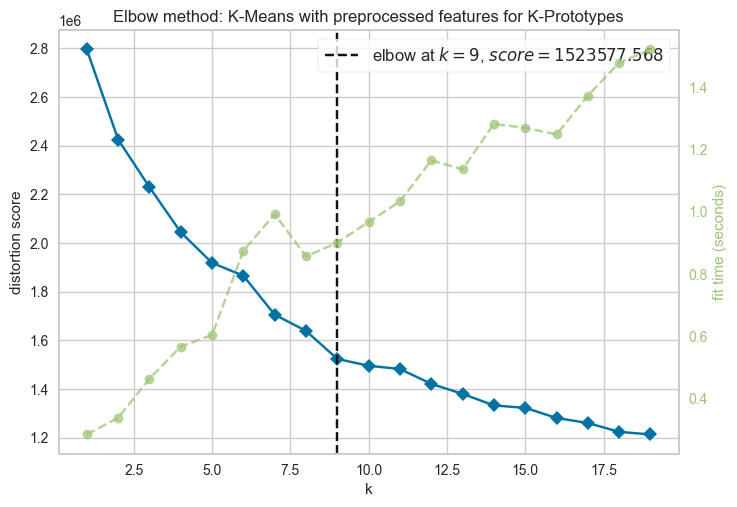

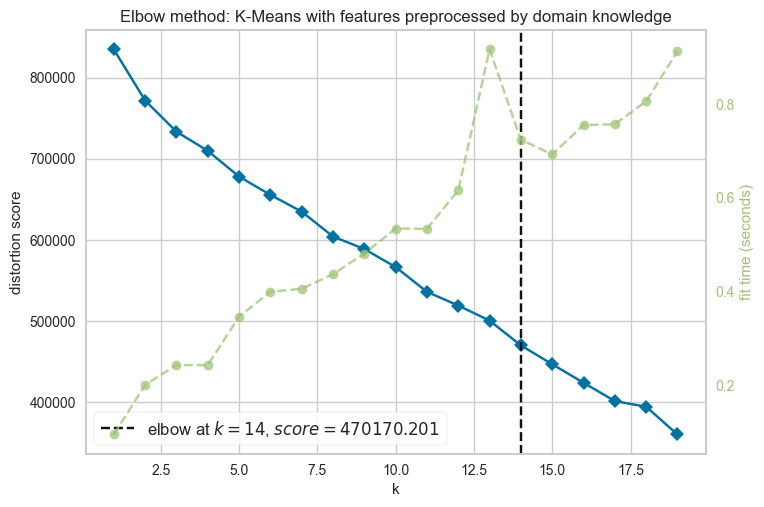

In [36]:
# "K-Means with features preprocessed as for K-Prototypes"
clustering_with_k_means(k_means_with_k_prototypes_preprocessed_features, K, False, 2, "Elbow method: K-Means with preprocessed features for K-Prototypes").to_pickle("data/rwanda/clustering_results/k_means_with_k_prototypes_preprocessed_features.pickle")

# "K-Means with features preprocessed with domain knowledge"
clustering_with_k_means(k_means_preprocessed_with_domain_knowledge, K, False, 3, "Elbow method: K-Means with features preprocessed by domain knowledge").to_pickle("data/rwanda/clustering_results/k_means_preprocessed_with_domain_knowledge.pickle")

## ... with manual init of centroids

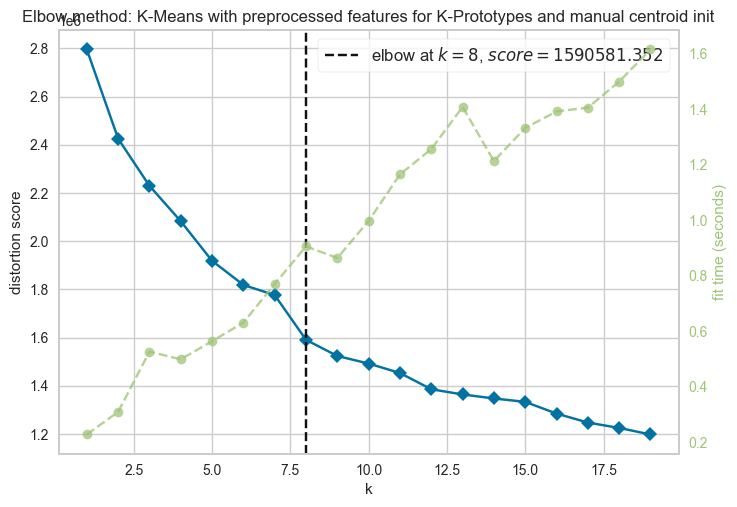

c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `l

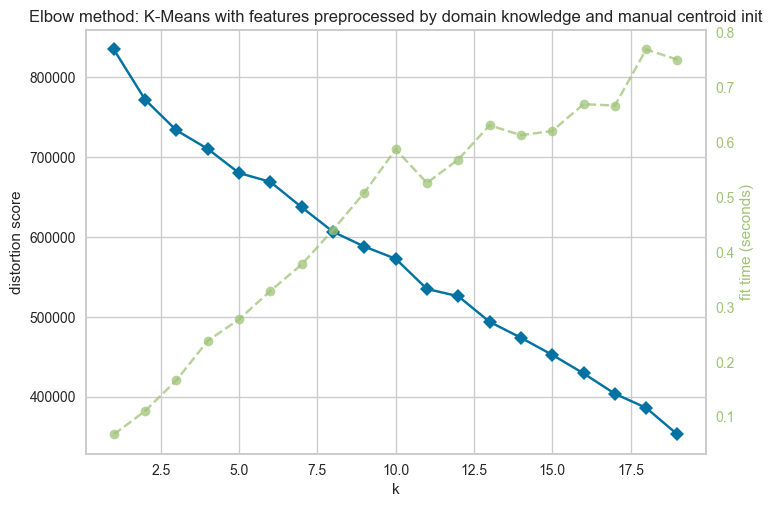

c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
# "K-Means with features preprocessed as for K-Prototypes"
clustering_with_k_means(k_means_manual_inint_with_k_prototypes_preprocessed_features, K, True, 4, "Elbow method: K-Means with preprocessed features for K-Prototypes and manual centroid init").to_pickle("data/rwanda/clustering_results/k_means_with_k_prototypes_preprocessed_features_and_manual_centroid_init.pickle")

# "K-Means with features preprocessed with domain knowledge"
clustering_with_k_means(k_means_manual_init_and_preprocessed_with_domain_knowledge, K, True, 5, "Elbow method: K-Means with features preprocessed by domain knowledge and manual centroid init").to_pickle("data/rwanda/clustering_results/k_means_preprocessed_with_domain_knowledge_and_manual_centroid_init.pickle")